Install Packages

In [ ]:
!pip install numpy matplotlib scipy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Imports

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import griddata

Define the 1D Burgers' Equation

In [ ]:
# Domain bounds
nu = 0.01 / np.pi
lb = np.array([-1.0, 0.0])   # x ∈ [-1,1], t ∈ [0,1]
ub = np.array([1.0, 1.0])

# Initial condition
def initial_condition(x):
    return -np.sin(np.pi * x)

PINN Architecture

In [ ]:
class FCNN(nn.Module):
    def __init__(self, layers):
        super(FCNN, self).__init__()
        self.activation = nn.Tanh()
        layer_list = []

        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(self.activation)

        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.model(x)

PDE Residual with Autograd

In [ ]:
def pde_residual(model, x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(torch.cat([x, t], dim=1))

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

    f = u_t + u * u_x - nu * u_xx
    return f


Training Data

In [ ]:
N_f = 10000   # collocation points for physics
N_u = 100     # initial/boundary points

# Random samples
x = np.random.uniform(-1, 1, (N_f, 1))
t = np.random.uniform(0, 1, (N_f, 1))

X_f = np.hstack((x, t))

# Initial and boundary data
x0 = np.linspace(-1, 1, N_u).reshape(-1, 1)               # Pop Thieves
t0 = np.zeros_like(x0)
u0 = initial_condition(x0)

# Convert to tensors
X_f_tensor = torch.tensor(X_f, dtype=torch.float32)
X0_tensor = torch.tensor(np.hstack((x0, t0)), dtype=torch.float32)
u0_tensor = torch.tensor(u0, dtype=torch.float32)

Loss Function

In [ ]:
def pinn_loss(model, X_f, X0, u0):
    x0 = X0[:, 0:1]
    t0 = X0[:, 1:2]

    u0_pred = model(torch.cat([x0, t0], dim=1))
    f_pred = pde_residual(model, X_f[:, 0:1], X_f[:, 1:2])

    loss_u = torch.mean((u0_pred - u0)**2)
    loss_f = torch.mean(f_pred**2)
    return loss_u + loss_f

Train the PINN

In [ ]:
layers = [2, 50, 50, 50, 1]
model = FCNN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5000):
    loss = pinn_loss(model, X_f_tensor, X0_tensor, u0_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

Epoch 0, Loss: 0.51273
Epoch 500, Loss: 0.08962
Epoch 1000, Loss: 0.07498
Epoch 1500, Loss: 0.04644
Epoch 2000, Loss: 0.02328
Epoch 2500, Loss: 0.01299
Epoch 3000, Loss: 0.00982
Epoch 3500, Loss: 0.00760
Epoch 4000, Loss: 0.00631
Epoch 4500, Loss: 0.00515


Evaluate the Model and Compare with FDM

In [ ]:
# Evaluate solution on grid
x_eval = np.linspace(-1, 1, 256)
t_eval = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_eval, t_eval)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
X_star_tensor = torch.tensor(X_star, dtype=torch.float32)
u_pred = model(X_star_tensor).detach().numpy().reshape(X.shape)

# True solution using spectral or finite difference (reference)
def burgers_exact(x, t, nu):
    from scipy.special import eval_legendre
    return -np.sin(np.pi * x) * np.exp(-np.pi**2 * nu * t)

U_true = burgers_exact(X, T, nu)

# L2 Error
error = np.linalg.norm(u_pred - U_true, 2) / np.linalg.norm(U_true, 2)
print(f"L2 relative error: {error:.4e}")

L2 relative error: 4.8546e-01


Visualize!!

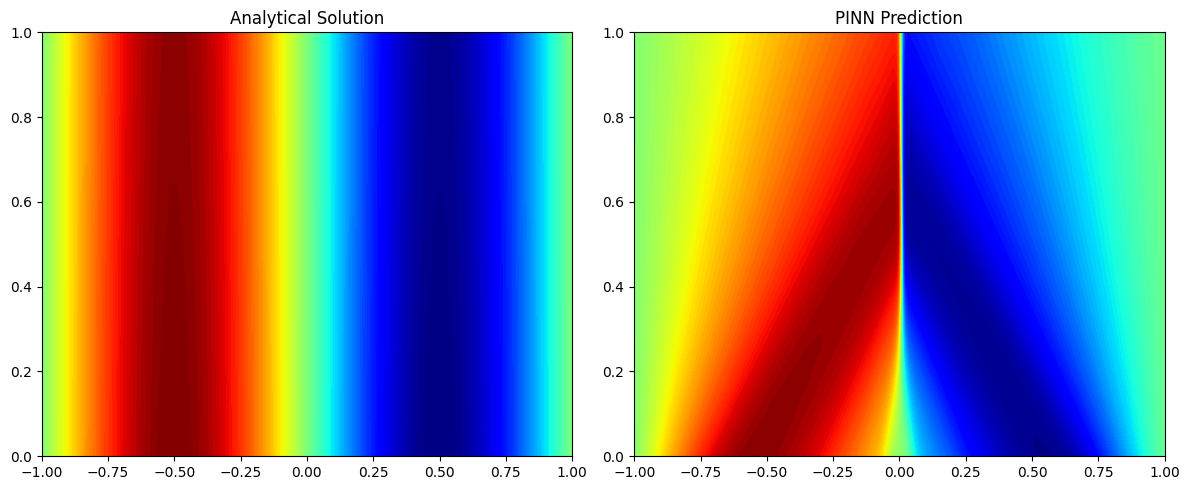

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(X, T, U_true, 100, cmap='jet')
plt.title("Analytical Solution")

plt.subplot(1, 2, 2)
plt.contourf(X, T, u_pred, 100, cmap='jet')
plt.title("PINN Prediction")
plt.tight_layout()
plt.show()